<a href="https://colab.research.google.com/github/Ismail-El-Moufakir/AI_Handall_Video_Analysis/blob/main/Fast_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset
import torchvision.transforms as tf
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import SGD
import numpy as np

In [ ]:
# preparing the dataset
class HandballDataSet(Dataset):
    def __init__(self,dir_path,csv_path,transform = None):
        self.annotations = pd.read_csv(csv_path)
        self.dir_path = dir_path
        self.transform = transform
        self.classes_items = self.annotations["class"].unique()
        self.classes = {self.classes_items[i]:i for i in range(len(self.classes_items))}
    def __len__(self):
        return len(self.annotations["filename"].unique())
    def __getitem__(self,idx):
        filename = self.annotations["filename"].unique()[idx]
        img_path = os.path.join(self.dir_path,filename)
        img = Image.open(img_path)
        Bounding_Boxes = self.annotations[["class","xmin","ymin","xmax","ymax"]][self.annotations["filename"] == filename]
        target = {"boxes" :[], "labels" : []}
        for _,row in Bounding_Boxes.iterrows():
            label  = row["class"]
            coordinates = [row["xmin"],row["ymin"],row["xmax"],row["ymax"]]
            target["boxes"].append(coordinates)
            target["labels"].append(self.classes[label])
        target["boxes"] = torch.as_tensor(target["boxes"],dtype=torch.float32)
        target["labels"] = torch.as_tensor(target["labels"],dtype=torch.int64)
        if self.transform:
            img =self.transform(img)
        return img, target



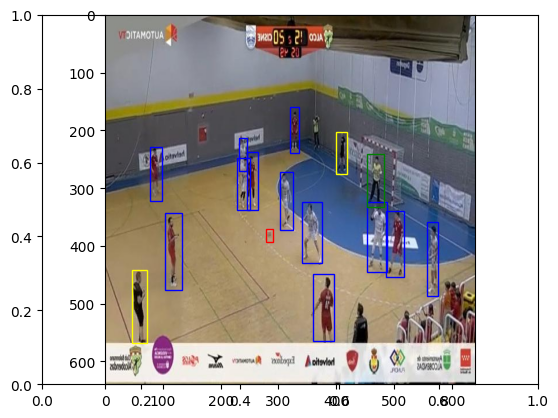

In [ ]:
# showing some samples of the Dataset
transform = tf.Compose(
    [tf.ToTensor()]
)
TrainDataset  = HandballDataSet(r"/content/Train_DataSet",r"/content/Train_DataSet/_annotations.csv",transform)
img,target = TrainDataset[0]
img = img.permute(1,2,0)
# drawing the bounding boxes:
fig = plt.figure()
fig.gca()
ax = fig.add_subplot(1,1,1)
ax.imshow(img)

colors = {0:"red",1:"blue",2:"yellow",3:"green",4:'brown'}
labels,boxes = target["labels"],target["boxes"]
for label,coordinates in zip(labels,boxes):
    xy = (coordinates[0],coordinates[1])
    height = coordinates[3] - coordinates[1]
    width = coordinates[2] - coordinates[0]
    Rectangle = patch.Rectangle(xy, width, height, edgecolor=colors[label.item()], facecolor="none")
    ax.add_patch(Rectangle)

fig.show()


In [ ]:
# Training model for detection
def collate_fn(batch):
    return tuple(zip(*batch))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
TrainLoader = DataLoader(TrainDataset,batch_size = 2,shuffle = True,collate_fn=collate_fn)
optimizer = SGD(model.parameters(),lr= 0.005,momentum=0.9,weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()
# Training loop
EPOCH = 5
model.train()
for epoch in range(EPOCH):
    total_loss = 0
    for imgs, targets in TrainLoader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        optimizer.zero_grad()

        # Forward pass to compute losses
        losses = model(imgs, targets)
        loss = sum(loss for loss in losses.values())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(TrainLoader)
    print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {avg_loss:.4f}")




Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.0MB/s]


Epoch [1/5], Loss: 1.3802
Epoch [2/5], Loss: 1.0672
Epoch [3/5], Loss: 0.9098
Epoch [4/5], Loss: 0.8321
Epoch [5/5], Loss: 0.7712


In [ ]:
import torch
from torch.utils.data import DataLoader


def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Set IoU threshold for counting correct detections
iou_threshold = 0.5


TestDataSet = HandballDataSet(r"/content/Test_DataSet", r"/content/Test_DataSet/_annotations.csv", transform)
TestLoader = DataLoader(TestDataSet, batch_size=1, shuffle=True, collate_fn=collate_fn)


model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


total_loss = 0.0
correct_detections = 0
total_detections = 0

with torch.no_grad():
    for images, targets in TestLoader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        detections = model(images)

        if model.training:
            loss_dict, _ = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()

        for target, detection in zip(targets, detections):
            target_boxes = target["boxes"]
            detected_boxes = detection["boxes"]

            for t_box in target_boxes:
                for d_box in detected_boxes:
                    iou = calculate_iou(t_box.cpu().numpy(), d_box.cpu().numpy())
                    if iou >= iou_threshold:
                        correct_detections += 1
                        break

            total_detections += len(target_boxes)

# Calculate average loss and accuracy
avg_loss = total_loss / len(TestLoader) if total_loss > 0 else None
accuracy = correct_detections / total_detections if total_detections > 0 else 0

if avg_loss:
    print(f"Average Loss: {avg_loss}")
print(f"Detection Accuracy: {accuracy * 100:.2f}%")


Detection Accuracy: 91.94%


In [ ]:
model_save_path = "player_detection_model.pth"

# Save the model parameters (state_dict)
torch.save(model.state_dict(), model_save_path)